# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 50000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (50000, 10)


Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      1  1303862400   
1                     0                       0      0  1346976000   
2                     1                       1      1  1219017600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...

In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


UserId   ProductId             ProfileName        Time  Score  \
0  #oc-R115TNMSPFT9I7  B007Y59HVM                 Breyton  1331510400      2   
1  #oc-R11D9D7SHXIJB9  B005HG9ET0  Louis E. Emory "hoppy"  1342396800      5   
2  #oc-R11DNU2NBKQ23Z  B007Y59HVM        Kim Cieszykowski  1348531200      1   
3  #oc-R11O5J5ZVQE25C  B005HG9ET0           Penguin Chick  1346889600      5   
4  #oc-R12KPBODL2B5ZD  B007OSBE1U   Christopher P. Presta  1348617600      1   

                                                Text  COUNT(*)  
0  Overall its just OK when considering the price...         2  
1  My wife has recurring extreme muscle spasms, u...         3  
2  This coffee is horrible and unfortunately not ...         2  
3  This will be the bottle that you grab from the...         3  
4  I didnt like this coffee. Instead of telling y...         2

In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

UserId   ProductId                      ProfileName        Time  \
80638  AZY10LLTJ71NX  B006P7E5ZI  undertheshrine "undertheshrine"  1334707200   

       Score                                               Text  COUNT(*)  
80638      5  I was recommended to try green tea extract to ...         5

In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

Id   ProductId         UserId      ProfileName  HelpfulnessNumerator  \
0   78445  B000HDL1RQ  AR5J8UI46CURR  Geetha Krishnan                     2   
1  138317  B000HDOPYC  AR5J8UI46CURR  Geetha Krishnan                     2   
2  138277  B000HDOPYM  AR5J8UI46CURR  Geetha Krishnan                     2   
3   73791  B000HDOPZG  AR5J8UI46CURR  Geetha Krishnan                     2   
4  155049  B000PAQ75C  AR5J8UI46CURR  Geetha Krishnan                     2   

   HelpfulnessDenominator  Score        Time  \
0                       2      5  1199577600   
1                       2      5  1199577600   
2                       2      5  1199577600   
3                       2      5  1199577600   
4                       2      5  1199577600   

                             Summary  \
0  LOACKER QUADRATINI VANILLA WAFERS   
1  LOACKER QUADRATINI VANILLA WAFERS   
2  LOACKER QUADRATINI VANILLA WAFERS   
3  LOACKER QUADRATINI VANILLA WAFERS   
4  LOACKER QUADRATINI VANILLA WAFERS   

                                                Text  
0  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
1  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
2  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
3  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
4  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...

As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(46072, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

92.144

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

Id   ProductId          UserId              ProfileName  \
0  64422  B000MIDROQ  A161DK06JJMCYF  J. E. Stephens "Jeanne"   
1  44737  B001EQ55RW  A2V0I904FH7ABY                      Ram   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     3                       1      5  1224892800   
1                     3                       2      4  1212883200   

                                        Summary  \
0             Bought This for My Son at College   
1  Pure cocoa taste with crunchy almonds inside   

                                                Text  
0  My son loves spaghetti so I didn't hesitate or...  
1  It was almost a 'love at first bite' - the per...

In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(46071, 10)


1    38479
0     7592
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [15]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [16]:
# Combining all the above stundents 
from tqdm import tqdm
from bs4 import BeautifulSoup

preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 46071/46071 [00:17<00:00, 2676.00it/s]


In [17]:
preprocessed_reviews[1500]

'great flavor low calories high nutrients high protein usually protein powders high priced high calories one great bargain tastes great highly recommend lady gym rats probably not macho enough guys since soy based'

# [5] Assignment 10: K-Means, Agglomerative & DBSCAN Clustering

<ol>
    <li><strong>Apply K-means Clustering on these feature sets:</strong>
        <ul>
    <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘k’ using the elbow-knee method (plot k vs inertia_)</li>
    <li>Once after you find the k clusters, plot the word cloud per each cluster so that at a single
go we can analyze the words in a cluster.</li>          
        </ul>
    </li>
    <br>
    <li><strong>Apply Agglomerative Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Apply agglomerative algorithm and try a different number of clusters like 2,5 etc.</li>
    <li>Same as that of K-means, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews or so(as this is very computationally expensive one)</li>
        </ul>
    </li>
    <br>
    <br>
    <li><strong>Apply DBSCAN Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘Eps’ using the <a href='https://stackoverflow.com/questions/12893492/choosing-eps-and-minpts-for-dbscan-r/48558030#48558030'>elbow-knee method.</a></li>
    <li>Same as before, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews for this as well.</li>
        </ul>
    </li>
</ol>

## [5.1] K-Means Clustering

### [5.1.1] Applying K-Means Clustering on BOW,<font color='red'> SET 1</font>



  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [01:11<04:44, 71.20s/it]

 40%|████      | 2/5 [03:23<04:28, 89.42s/it]

 60%|██████    | 3/5 [06:04<03:41, 110.98s/it]

 80%|████████  | 4/5 [10:59<02:46, 166.21s/it]

100%|██████████| 5/5 [16:25<00:00, 214.13s/it]

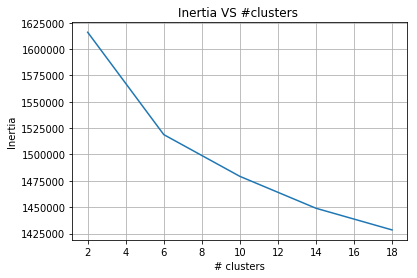

In [74]:
from sklearn.cluster import KMeans
count_vect = CountVectorizer(min_df = 500)
X_train=count_vect.fit_transform(preprocessed_reviews)
k_values=np.arange(2,20,4)
inertia_values=[]
for k in tqdm(k_values):
    model=KMeans(n_clusters=k, n_jobs=-1)
    model.fit(X_train)
    inertia_values.append(model.inertia_)

plt.plot(k_values, inertia_values)
plt.xlabel('# clusters')
plt.ylabel('Inertia')
plt.title('Inertia VS #clusters ')
plt.grid()
plt.show()

In [75]:
best_km=KMeans(n_clusters=6, n_jobs=-1)
best_km.fit(X_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [76]:
cluster_0=[]
cluster_1=[]
cluster_2=[]
cluster_3=[]
cluster_4=[]
cluster_5=[]
for i in range(len(preprocessed_reviews)):
    if best_km.labels_[i] == 0:
        cluster_0.append(preprocessed_reviews[i])
    elif best_km.labels_[i] == 1:
        cluster_1.append(preprocessed_reviews[i])
    elif best_km.labels_[i] == 2:
        cluster_2.append(preprocessed_reviews[i])
    elif best_km.labels_[i] == 3:
        cluster_3.append(preprocessed_reviews[i])
    elif best_km.labels_[i] == 4:
        cluster_4.append(preprocessed_reviews[i])
    else:
        cluster_5.append(preprocessed_reviews[i])

### [5.1.2] Wordclouds of clusters obtained after applying k-means on BOW<font color='red'> SET 1</font>

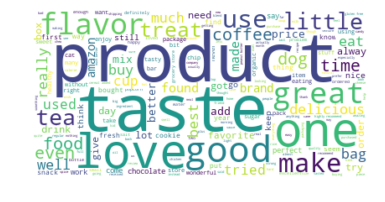

In [77]:
# Please write all the code with proper documentation

from wordcloud import WordCloud
data=''
for sent in cluster_0:
        data += sent

#https://www.geeksforgeeks.org/generating-word-cloud-python/
wordcloud = WordCloud(background_color="white").generate(data)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


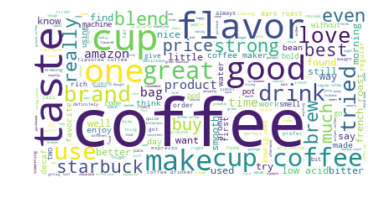

In [78]:
# Please write all the code with proper documentation
data=''
for sent in cluster_1:
        data += sent

#https://www.geeksforgeeks.org/generating-word-cloud-python/
wordcloud = WordCloud(background_color="white").generate(data)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


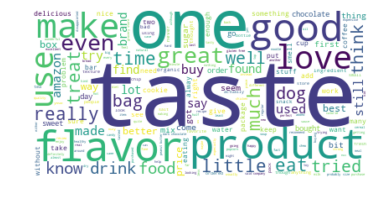

In [79]:
# Please write all the code with proper documentation
data=''
for sent in cluster_2:
        data += sent

#https://www.geeksforgeeks.org/generating-word-cloud-python/
wordcloud = WordCloud(background_color="white").generate(data)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


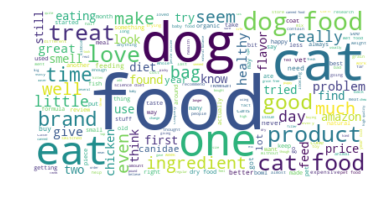

In [80]:
# Please write all the code with proper documentation
data=''
for sent in cluster_3:
        data += sent

#https://www.geeksforgeeks.org/generating-word-cloud-python/
wordcloud = WordCloud(background_color="white").generate(data)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


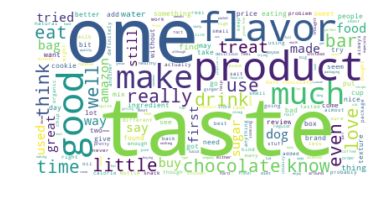

In [81]:
# Please write all the code with proper documentation
data=''
for sent in cluster_4:
        data += sent

#https://www.geeksforgeeks.org/generating-word-cloud-python/
wordcloud = WordCloud(background_color="white").generate(data)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


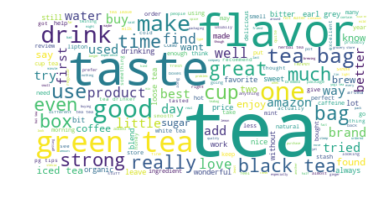

In [82]:
# Please write all the code with proper documentation
data=''
for sent in cluster_5:
        data += sent

#https://www.geeksforgeeks.org/generating-word-cloud-python/
wordcloud = WordCloud(background_color="white").generate(data)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


### [5.1.3] Applying K-Means Clustering on TFIDF,<font color='red'> SET 2</font>



  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [02:09<08:38, 129.58s/it]

 40%|████      | 2/5 [04:21<06:30, 130.20s/it]

 60%|██████    | 3/5 [07:34<04:58, 149.06s/it]

 80%|████████  | 4/5 [10:22<02:34, 154.89s/it]

100%|██████████| 5/5 [14:47<00:00, 187.80s/it]

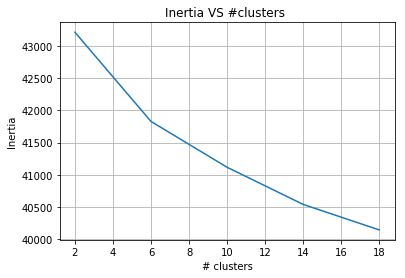

In [83]:
from sklearn.cluster import KMeans
count_vect = TfidfVectorizer(min_df = 500)
X_train=count_vect.fit_transform(preprocessed_reviews)
k_values=np.arange(2,20,4)
inertia_values=[]
for k in tqdm(k_values):
    model=KMeans(n_clusters=k, n_jobs=-1)
    model.fit(X_train)
    inertia_values.append(model.inertia_)

plt.plot(k_values, inertia_values)
plt.xlabel('# clusters')
plt.ylabel('Inertia')
plt.title('Inertia VS #clusters ')
plt.grid()
plt.show()

In [84]:
best_km=KMeans(n_clusters=6, n_jobs=-1)
best_km.fit(X_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [85]:
cluster_0=[]
cluster_1=[]
cluster_2=[]
cluster_3=[]
cluster_4=[]
cluster_5=[]
for i in range(len(preprocessed_reviews)):
    if best_km.labels_[i] == 0:
        cluster_0.append(preprocessed_reviews[i])
    elif best_km.labels_[i] == 1:
        cluster_1.append(preprocessed_reviews[i])
    elif best_km.labels_[i] == 2:
        cluster_2.append(preprocessed_reviews[i])
    elif best_km.labels_[i] == 3:
        cluster_3.append(preprocessed_reviews[i])
    elif best_km.labels_[i] == 4:
        cluster_4.append(preprocessed_reviews[i])
    else:
        cluster_5.append(preprocessed_reviews[i])

### [5.1.4] Wordclouds of clusters obtained after applying k-means on TFIDF<font color='red'> SET 2</font>

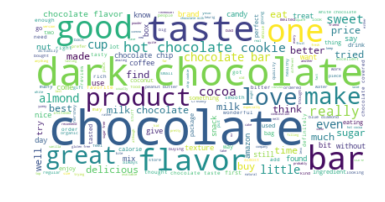

In [86]:
# Please write all the code with proper documentation

from wordcloud import WordCloud
data=''
for sent in cluster_0:
        data += sent

#https://www.geeksforgeeks.org/generating-word-cloud-python/
wordcloud = WordCloud(background_color="white").generate(data)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


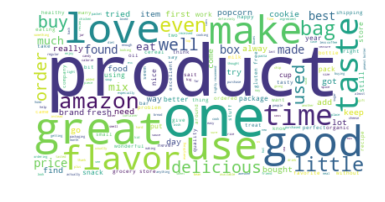

In [87]:
# Please write all the code with proper documentation
data=''
for sent in cluster_1:
        data += sent

#https://www.geeksforgeeks.org/generating-word-cloud-python/
wordcloud = WordCloud(background_color="white").generate(data)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


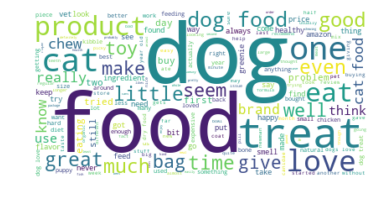

In [88]:
# Please write all the code with proper documentation
data=''
for sent in cluster_2:
        data += sent

#https://www.geeksforgeeks.org/generating-word-cloud-python/
wordcloud = WordCloud(background_color="white").generate(data)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


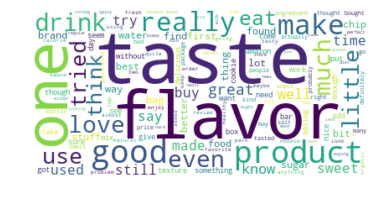

In [89]:
# Please write all the code with proper documentation
data=''
for sent in cluster_3:
        data += sent

#https://www.geeksforgeeks.org/generating-word-cloud-python/
wordcloud = WordCloud(background_color="white").generate(data)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


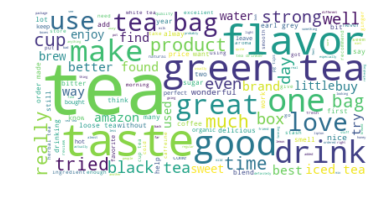

In [90]:
# Please write all the code with proper documentation
data=''
for sent in cluster_4:
        data += sent

#https://www.geeksforgeeks.org/generating-word-cloud-python/
wordcloud = WordCloud(background_color="white").generate(data)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


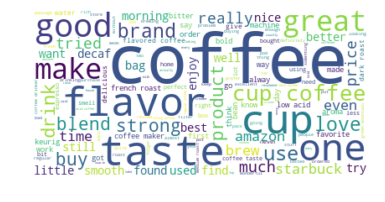

In [91]:
# Please write all the code with proper documentation
data=''
for sent in cluster_5:
        data += sent

#https://www.geeksforgeeks.org/generating-word-cloud-python/
wordcloud = WordCloud(background_color="white").generate(data)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


### [5.1.5] Applying K-Means Clustering on AVG W2V,<font color='red'> SET 3</font>

In [19]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation

def w2v_fit(preprocessed_reviews):
    i=0
    list_of_sentance=[]
    for sentance in preprocessed_reviews:
        list_of_sentance.append(sentance.split())

    is_your_ram_gt_16g=False
    want_to_use_google_w2v = False
    want_to_train_w2v = True

    if want_to_train_w2v:
        # min_count = 5 considers only words that occured atleast 5 times
        w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
        #print(w2v_model.wv.most_similar('great'))
        #print('='*50)
        #print(w2v_model.wv.most_similar('worst'))

    elif want_to_use_google_w2v and is_your_ram_gt_16g:
        if os.path.isfile('GoogleNews-vectors-negative300.bin'):
            w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
            print(w2v_model.wv.most_similar('great'))
            print(w2v_model.wv.most_similar('worst'))
        else:
            print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")
    return w2v_model

In [20]:
# average Word2Vec
# compute average word2vec for each review.
def avg_w2v_transform(w2v_model,list_of_sentence):
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    #w2v_model = word2Vec(list_of_sentence)
    w2v_words = list(w2v_model.wv.vocab)
    for sent in tqdm(list_of_sentence): # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        cnt_words =0; # num of words with a valid vector in the sentence/review
        word_len = 0;
        for word in sent.split(): # for each word in a review/sentence
            if word in w2v_words:
                word_len += 1
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vec = sent_vec.tolist()
        sent_vec.append(word_len) 
        sent_vectors.append(sent_vec)
    return np.array(sent_vectors)



  0%|          | 0/46071 [00:00<?, ?it/s]

  0%|          | 75/46071 [00:00<01:01, 749.94it/s]

[('awesome', 0.8226785063743591), ('fantastic', 0.8080378770828247), ('terrific', 0.7992591261863708), ('excellent', 0.7811538577079773), ('amazing', 0.7714901566505432), ('good', 0.7673871517181396), ('wonderful', 0.7428163886070251), ('perfect', 0.7398779392242432), ('decent', 0.695073127746582), ('fabulous', 0.6781037449836731)]
[('greatest', 0.7617276310920715), ('nastiest', 0.7227798104286194), ('best', 0.7207158207893372), ('awful', 0.6902266144752502), ('ive', 0.6843034029006958), ('experienced', 0.6837616562843323), ('closest', 0.6763356328010559), ('terrible', 0.6646451354026794), ('tastiest', 0.6613786220550537), ('disgusting', 0.6418783068656921)]




  0%|          | 123/46071 [00:00<01:15, 610.75it/s]

  0%|          | 175/46071 [00:00<01:19, 579.47it/s]

  1%|          | 274/46071 [00:00<01:09, 661.27it/s]

  1%|          | 360/46071 [00:00<01:04, 706.00it/s]

  1%|          | 431/46071 [00:00<01:04, 703.87it/s]

  1%|          | 497/46071 [00:00<01:09, 652.90it/s]

  1%|          | 560/46071 [00:00<01:11, 640.47it/s]

  1%|▏         | 645/46071 [00:00<01:05, 690.72it/s]

  2%|▏         | 714/46071 [00:01<01:06, 686.48it/s]

  2%|▏         | 783/46071 [00:01<01:08, 661.14it/s]

  2%|▏         | 861/46071 [00:01<01:05, 690.01it/s]

  2%|▏         | 931/46071 [00:01<01:15, 596.29it/s]

  2%|▏         | 1008/46071 [00:01<01:10, 639.15it/s]

  2%|▏         | 1075/46071 [00:01<01:23, 541.56it/s]

  2%|▏         | 1145/46071 [00:01<01:17, 579.59it/s]

  3%|▎         | 1216/46071 [00:01<01:13, 611.83it/s]

  3%|▎         | 1328/46071 [00:01<01:03, 707.14it/s]

  3%|▎         | 1413/46071 [00:02<01:00, 743.90it/s]

  3%|▎         | 149

 49%|████▉     | 22575/46071 [00:29<00:40, 577.12it/s]

 49%|████▉     | 22638/46071 [00:30<00:45, 510.93it/s]

 49%|████▉     | 22722/46071 [00:30<00:40, 577.74it/s]

 50%|████▉     | 22809/46071 [00:30<00:36, 641.71it/s]

 50%|████▉     | 22882/46071 [00:30<00:34, 663.24it/s]

 50%|████▉     | 22954/46071 [00:30<00:35, 650.42it/s]

 50%|█████     | 23039/46071 [00:30<00:33, 691.58it/s]

 50%|█████     | 23112/46071 [00:30<00:34, 659.36it/s]

 50%|█████     | 23189/46071 [00:30<00:33, 688.74it/s]

 50%|█████     | 23260/46071 [00:30<00:36, 630.42it/s]

 51%|█████     | 23342/46071 [00:30<00:33, 675.11it/s]

 51%|█████     | 23413/46071 [00:31<00:34, 650.67it/s]

 51%|█████     | 23501/46071 [00:31<00:32, 700.62it/s]

 51%|█████     | 23579/46071 [00:31<00:31, 714.46it/s]

 51%|█████▏    | 23668/46071 [00:31<00:29, 755.79it/s]

 52%|█████▏    | 23750/46071 [00:31<00:29, 765.75it/s]

 52%|█████▏    | 23828/46071 [00:31<00:32, 693.66it/s]

 52%|█████▏    | 23902/46071 [00:31<00:31, 706.1

 96%|█████████▌| 44319/46071 [00:59<00:02, 684.23it/s]

 96%|█████████▋| 44416/46071 [00:59<00:02, 748.57it/s]

 97%|█████████▋| 44497/46071 [01:00<00:02, 708.78it/s]

 97%|█████████▋| 44573/46071 [01:00<00:02, 671.87it/s]

 97%|█████████▋| 44717/46071 [01:00<00:01, 799.39it/s]

 97%|█████████▋| 44848/46071 [01:00<00:01, 904.58it/s]

 98%|█████████▊| 44957/46071 [01:00<00:01, 952.99it/s]

 98%|█████████▊| 45063/46071 [01:00<00:01, 953.32it/s]

 98%|█████████▊| 45166/46071 [01:00<00:01, 752.60it/s]

 98%|█████████▊| 45253/46071 [01:00<00:01, 718.47it/s]

 98%|█████████▊| 45342/46071 [01:01<00:00, 756.39it/s]

 99%|█████████▊| 45425/46071 [01:01<00:00, 697.42it/s]

 99%|█████████▉| 45511/46071 [01:01<00:00, 739.15it/s]

 99%|█████████▉| 45607/46071 [01:01<00:00, 790.94it/s]

 99%|█████████▉| 45699/46071 [01:01<00:00, 825.54it/s]

 99%|█████████▉| 45785/46071 [01:01<00:00, 803.59it/s]

100%|█████████▉| 45868/46071 [01:01<00:00, 743.72it/s]

100%|█████████▉| 45945/46071 [01:01<00:00, 727.8

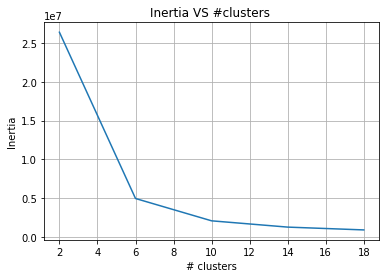

In [95]:
from sklearn.cluster import KMeans
w2v_model = w2v_fit(preprocessed_reviews)
X_train = avg_w2v_transform(w2v_model,preprocessed_reviews)

k_values=np.arange(2,20,4)
inertia_values=[]
for k in tqdm(k_values):
    model=KMeans(n_clusters=k, n_jobs=-1)
    model.fit(X_train)
    inertia_values.append(model.inertia_)

plt.plot(k_values, inertia_values)
plt.xlabel('# clusters')
plt.ylabel('Inertia')
plt.title('Inertia VS #clusters ')
plt.grid()
plt.show()

In [96]:
best_km=KMeans(n_clusters=6, n_jobs=-1)
best_km.fit(X_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [97]:
cluster_0=[]
cluster_1=[]
cluster_2=[]
cluster_3=[]
cluster_4=[]
cluster_5=[]
for i in range(len(preprocessed_reviews)):
    if best_km.labels_[i] == 0:
        cluster_0.append(preprocessed_reviews[i])
    elif best_km.labels_[i] == 1:
        cluster_1.append(preprocessed_reviews[i])
    elif best_km.labels_[i] == 2:
        cluster_2.append(preprocessed_reviews[i])
    elif best_km.labels_[i] == 3:
        cluster_3.append(preprocessed_reviews[i])
    elif best_k m.labels_[i] == 4:
        cluster_4.append(preprocessed_reviews[i])
    else:
        cluster_5.append(preprocessed_reviews[i])

### [5.1.6] Wordclouds of clusters obtained after applying k-means on AVG W2V<font color='red'> SET 3</font>

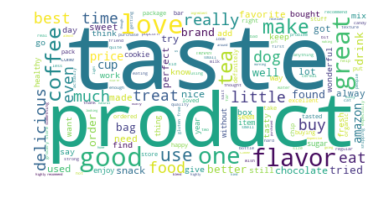

In [98]:
# Please write all the code with proper documentation

from wordcloud import WordCloud
data=''
for sent in cluster_0:
        data += sent

#https://www.geeksforgeeks.org/generating-word-cloud-python/
wordcloud = WordCloud(background_color="white").generate(data)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


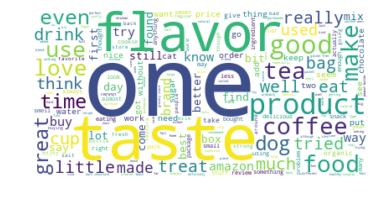

In [99]:
# Please write all the code with proper documentation
data=''
for sent in cluster_1:
        data += sent

#https://www.geeksforgeeks.org/generating-word-cloud-python/
wordcloud = WordCloud(background_color="white").generate(data)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


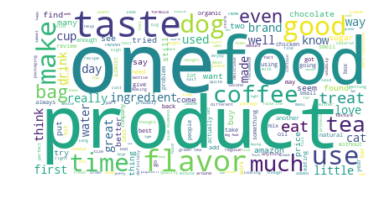

In [100]:
# Please write all the code with proper documentation
data=''
for sent in cluster_2:
        data += sent

#https://www.geeksforgeeks.org/generating-word-cloud-python/
wordcloud = WordCloud(background_color="white").generate(data)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


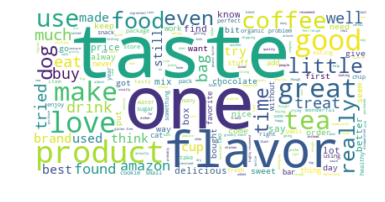

In [101]:
# Please write all the code with proper documentation
data=''
for sent in cluster_3:
        data += sent

#https://www.geeksforgeeks.org/generating-word-cloud-python/
wordcloud = WordCloud(background_color="white").generate(data)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


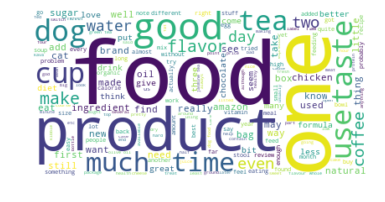

In [102]:
# Please write all the code with proper documentation
data=''
for sent in cluster_4:
        data += sent

#https://www.geeksforgeeks.org/generating-word-cloud-python/
wordcloud = WordCloud(background_color="white").generate(data)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


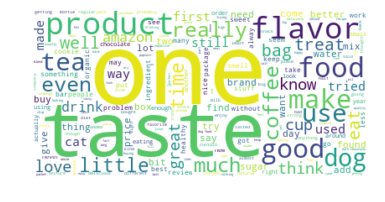

In [103]:
# Please write all the code with proper documentation
data=''
for sent in cluster_5:
        data += sent

#https://www.geeksforgeeks.org/generating-word-cloud-python/
wordcloud = WordCloud(background_color="white").generate(data)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


### [5.1.7] Applying K-Means Clustering on TFIDF W2V,<font color='red'> SET 4</font>

In [21]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
def tf_idf_transform(model,w_model,list_of_sentence):
    # TF-IDF weighted Word2Vec
    dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
    tfidf_feat = model.get_feature_names() # tfidf words/col-names
    # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
    w2v_words = list(w_model.wv.vocab)
    tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    #print(list_of_sentence)
    for sent in list_of_sentence: # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        #print(sent)
        #print("+++++++")
        for word in sent.split():
            #print(word)# for each word in a review/sentence
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
    #             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
                #print(sent_vec)
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1
    return tfidf_sent_vectors

[('awesome', 0.8258119821548462), ('fantastic', 0.8112775087356567), ('terrific', 0.7947898507118225), ('good', 0.7885767817497253), ('amazing', 0.7747929692268372), ('excellent', 0.7724969387054443), ('wonderful', 0.7393082976341248), ('perfect', 0.7204089164733887), ('fabulous', 0.7024619579315186), ('decent', 0.6786200404167175)]
[('best', 0.7250120639801025), ('greatest', 0.719957172870636), ('nastiest', 0.7186100482940674), ('awful', 0.6626880764961243), ('experienced', 0.6608601212501526), ('closest', 0.6550818085670471), ('ive', 0.6521348357200623), ('eaten', 0.6439424753189087), ('disgusting', 0.6360682249069214), ('terrible', 0.6254918575286865)]




 89%|████████▉ | 41022/46071 [01:21<00:09, 526.15it/s]


  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:03,  1.17it/s]


 40%|████      | 2/5 [00:02<00:03,  1.10s/it]


 60%|██████    | 3/5 [00:05<00:03,  1.53s/it]


 80%|████████  | 4/5 [00:07<00:01,  1.94s/it]


100%|██████████| 5/5 [00:12<00:00,  2.69s/it]

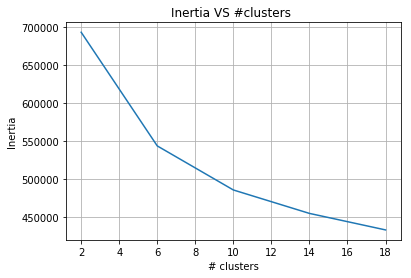

In [107]:
from sklearn.cluster import KMeans

model = TfidfVectorizer(min_df = 500)
model.fit(preprocessed_reviews)
w2v_model = w2v_fit(preprocessed_reviews)

X_train = tf_idf_transform(model,w2v_model,preprocessed_reviews)

k_values=np.arange(2,20,4)
inertia_values=[]
for k in tqdm(k_values):
    model=KMeans(n_clusters=k, n_jobs=-1)
    model.fit(X_train)
    inertia_values.append(model.inertia_)

plt.plot(k_values, inertia_values)
plt.xlabel('# clusters')
plt.ylabel('Inertia')
plt.title('Inertia VS #clusters ')
plt.grid()
plt.show()

In [108]:
best_km=KMeans(n_clusters=6, n_jobs=-1)
best_km.fit(X_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [110]:
cluster_0=[]
cluster_1=[]
cluster_2=[]
cluster_3=[]
cluster_4=[]
cluster_5=[]
for i in range(len(preprocessed_reviews)):
    if best_km.labels_[i] == 0:
        cluster_0.append(preprocessed_reviews[i])
    elif best_km.labels_[i] == 1:
        cluster_1.append(preprocessed_reviews[i])
    elif best_km.labels_[i] == 2:
        cluster_2.append(preprocessed_reviews[i])
    elif best_km.labels_[i] == 3:
        cluster_3.append(preprocessed_reviews[i])
    elif best_km.labels_[i] == 4:
        cluster_4.append(preprocessed_reviews[i])
    else:
        cluster_5.append(preprocessed_reviews[i])

### [5.1.8] Wordclouds of clusters obtained after applying k-means on TFIDF W2V<font color='red'> SET 4</font>

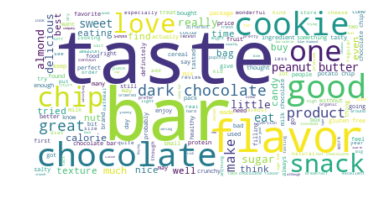

In [112]:
# Please write all the code with proper documentation

from wordcloud import WordCloud
data=''
for sent in cluster_0:
        data += sent

#https://www.geeksforgeeks.org/generating-word-cloud-python/
wordcloud = WordCloud(background_color="white").generate(data)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


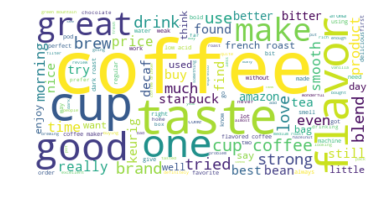

In [113]:
# Please write all the code with proper documentation
data=''
for sent in cluster_1:
        data += sent

#https://www.geeksforgeeks.org/generating-word-cloud-python/
wordcloud = WordCloud(background_color="white").generate(data)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


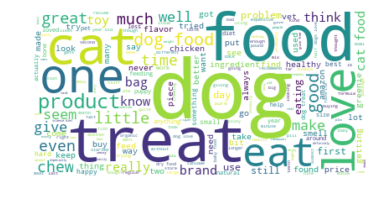

In [114]:
# Please write all the code with proper documentation
data=''
for sent in cluster_2:
        data += sent

#https://www.geeksforgeeks.org/generating-word-cloud-python/
wordcloud = WordCloud(background_color="white").generate(data)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


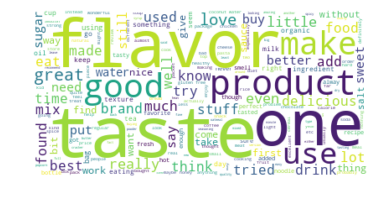

In [115]:
# Please write all the code with proper documentation
data=''
for sent in cluster_3:
        data += sent

#https://www.geeksforgeeks.org/generating-word-cloud-python/
wordcloud = WordCloud(background_color="white").generate(data)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


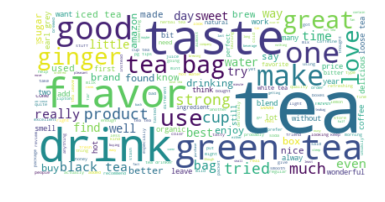

In [116]:
# Please write all the code with proper documentation
data=''
for sent in cluster_4:
        data += sent

#https://www.geeksforgeeks.org/generating-word-cloud-python/
wordcloud = WordCloud(background_color="white").generate(data)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


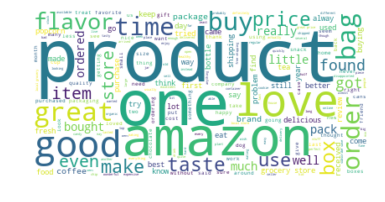

In [117]:
# Please write all the code with proper documentation
data=''
for sent in cluster_5:
        data += sent

#https://www.geeksforgeeks.org/generating-word-cloud-python/
wordcloud = WordCloud(background_color="white").generate(data)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


## [5.2] Agglomerative Clustering

### [5.2.1] Applying Agglomerative Clustering on AVG W2V,<font color='red'> SET 3</font>

In [118]:
# Please write all the code with proper documentation
preprocessed_reviews = preprocessed_reviews[:3000]


               ======================================== K = 2 =============================================

In [132]:
from sklearn.cluster import AgglomerativeClustering
w2v_model = w2v_fit(preprocessed_reviews)
X_train = avg_w2v_transform(w2v_model,preprocessed_reviews)

model=AgglomerativeClustering(n_clusters=2).fit(X_train)




  0%|          | 0/3000 [00:00<?, ?it/s]


  4%|▍         | 124/3000 [00:00<00:02, 1235.01it/s]


  9%|▊         | 257/3000 [00:00<00:02, 1259.22it/s]


 14%|█▎        | 407/3000 [00:00<00:01, 1320.67it/s]


 18%|█▊        | 530/3000 [00:00<00:01, 1289.65it/s]


 22%|██▏       | 672/3000 [00:00<00:01, 1325.31it/s]


 27%|██▋       | 811/3000 [00:00<00:01, 1344.06it/s]


 31%|███       | 932/3000 [00:00<00:01, 1291.61it/s]


 35%|███▌      | 1052/3000 [00:00<00:01, 1253.52it/s]


 40%|███▉      | 1188/3000 [00:00<00:01, 1282.94it/s]


 47%|████▋     | 1402/3000 [00:01<00:01, 1457.52it/s]


 53%|█████▎    | 1581/3000 [00:01<00:00, 1540.98it/s]


 58%|█████▊    | 1755/3000 [00:01<00:00, 1569.67it/s]


 65%|██████▍   | 1941/3000 [00:01<00:00, 1645.65it/s]


 70%|███████   | 2110/3000 [00:01<00:00, 1556.46it/s]


 76%|███████▌  | 2270/3000 [00:01<00:00, 1477.38it/s]


 81%|████████  | 2421/3000 [00:01<00:00, 1482.16it/s]


 86%|████████▌ | 2572/3000 [00:01<00:00, 1490.34it/s]


 91%|████

In [133]:
cluster_0=[]
cluster_1=[]
for i in range(len(preprocessed_reviews)):
    if best_km.labels_[i] == 0:
        cluster_0.append(preprocessed_reviews[i])
    else:
        cluster_1.append(preprocessed_reviews[i])

### [5.2.2] Wordclouds of clusters obtained after applying Agglomerative Clustering on AVG W2V<font color='red'> SET 3</font>

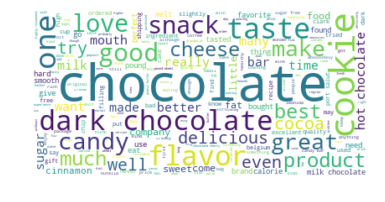

In [134]:
# Please write all the code with proper documentation

from wordcloud import WordCloud
data=''
for sent in cluster_0:
        data += sent

#https://www.geeksforgeeks.org/generating-word-cloud-python/
wordcloud = WordCloud(background_color="white").generate(data)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


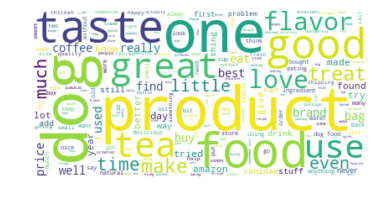

In [135]:
# Please write all the code with proper documentation
data=''
for sent in cluster_1:
        data += sent

#https://www.geeksforgeeks.org/generating-word-cloud-python/
wordcloud = WordCloud(background_color="white").generate(data)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


             ======================================== K = 3 =============================================

In [136]:

model=AgglomerativeClustering(n_clusters=3).fit(X_train)

In [137]:
cluster_0=[]
cluster_1=[]
cluster_2=[]
for i in range(len(preprocessed_reviews)):
    if best_km.labels_[i] == 0:
        cluster_0.append(preprocessed_reviews[i])
    elif best_km.labels_[i] == 1:
        cluster_1.append(preprocessed_reviews[i])
    else:
        cluster_2.append(preprocessed_reviews[i])

### [5.2.2] Wordclouds of clusters obtained after applying Agglomerative Clustering on AVG W2V<font color='red'> SET 3</font>

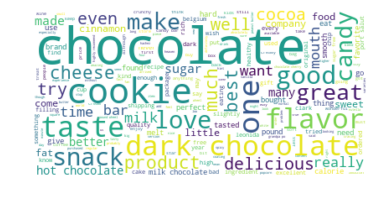

In [138]:
# Please write all the code with proper documentation

from wordcloud import WordCloud
data=''
for sent in cluster_0:
        data += sent

#https://www.geeksforgeeks.org/generating-word-cloud-python/
wordcloud = WordCloud(background_color="white").generate(data)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


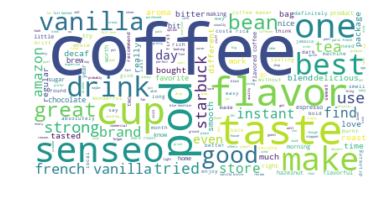

In [139]:
# Please write all the code with proper documentation
data=''
for sent in cluster_1:
        data += sent

#https://www.geeksforgeeks.org/generating-word-cloud-python/
wordcloud = WordCloud(background_color="white").generate(data)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


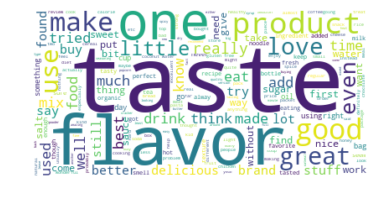

In [140]:
# Please write all the code with proper documentation

from wordcloud import WordCloud
data=''
for sent in cluster_3:
        data += sent

#https://www.geeksforgeeks.org/generating-word-cloud-python/
wordcloud = WordCloud(background_color="white").generate(data)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


### [5.2.3] Applying Agglomerative Clustering on TFIDF W2V,<font color='red'> SET 4</font>

               ======================================== K = 2 =============================================

In [141]:
from sklearn.cluster import AgglomerativeClustering
model = TfidfVectorizer(min_df = 500)
model.fit(preprocessed_reviews)
w2v_model = w2v_fit(preprocessed_reviews)

X_train = tf_idf_transform(model,w2v_model,preprocessed_reviews)

model=AgglomerativeClustering(n_clusters=2).fit(X_train)

In [142]:
cluster_0=[]
cluster_1=[]
for i in range(len(preprocessed_reviews)):
    if best_km.labels_[i] == 0:
        cluster_0.append(preprocessed_reviews[i])
    else:
        cluster_1.append(preprocessed_reviews[i])

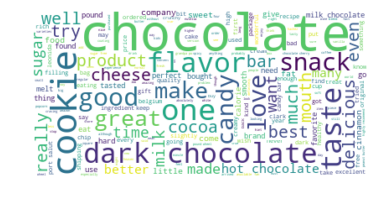

In [143]:
# Please write all the code with proper documentation

from wordcloud import WordCloud
data=''
for sent in cluster_0:
        data += sent

#https://www.geeksforgeeks.org/generating-word-cloud-python/
wordcloud = WordCloud(background_color="white").generate(data)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


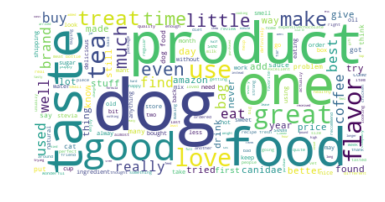

In [144]:
# Please write all the code with proper documentation
data=''
for sent in cluster_1:
        data += sent

#https://www.geeksforgeeks.org/generating-word-cloud-python/
wordcloud = WordCloud(background_color="white").generate(data)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


             ======================================== K = 3 =============================================

In [145]:

model=AgglomerativeClustering(n_clusters=3).fit(X_train)

In [146]:
cluster_0=[]
cluster_1=[]
cluster_2=[]
for i in range(len(preprocessed_reviews)):
    if best_km.labels_[i] == 0:
        cluster_0.append(preprocessed_reviews[i])
    elif best_km.labels_[i] == 1:
        cluster_1.append(preprocessed_reviews[i])
    else:
        cluster_2.append(preprocessed_reviews[i])

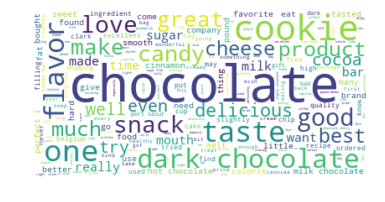

In [147]:
# Please write all the code with proper documentation

from wordcloud import WordCloud
data=''
for sent in cluster_0:
        data += sent

#https://www.geeksforgeeks.org/generating-word-cloud-python/
wordcloud = WordCloud(background_color="white").generate(data)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


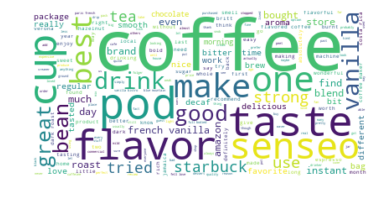

In [148]:
# Please write all the code with proper documentation
data=''
for sent in cluster_1:
        data += sent

#https://www.geeksforgeeks.org/generating-word-cloud-python/
wordcloud = WordCloud(background_color="white").generate(data)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


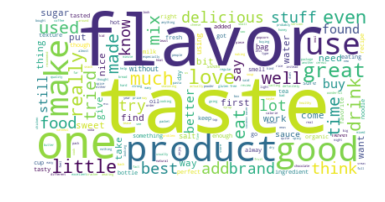

In [149]:
# Please write all the code with proper documentation

from wordcloud import WordCloud
data=''
for sent in cluster_3:
        data += sent

#https://www.geeksforgeeks.org/generating-word-cloud-python/
wordcloud = WordCloud(background_color="white").generate(data)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


## [5.3] DBSCAN Clustering

### [5.3.1] Applying DBSCAN on AVG W2V,<font color='red'> SET 3</font>

In [47]:
# Please write all the code with proper documentation
w2v_model = w2v_fit(preprocessed_reviews)
X_train = avg_w2v_transform(w2v_model,preprocessed_reviews)

100%|██████████| 46071/46071 [00:55<00:00, 832.92it/s] 


In [48]:
from sklearn.neighbors import NearestNeighbors


In [49]:
print(X_train.shape)

(46071, 51)


In [50]:
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler(with_mean=False)
X_train = scalar.fit_transform(X_train)


In [51]:
min_sample_value = 2 * (X_train.shape[1])

In [52]:

neigh = NearestNeighbors(n_neighbors=X_train.shape[0])
nbrs = neigh.fit(X_train)
distances, indices = nbrs.kneighbors(X_train)

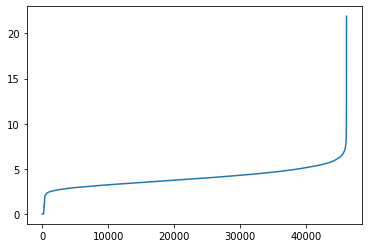

In [53]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

            =================================== eps=5 ===========================================

In [54]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=5, n_jobs=-1, min_samples=min_sample_value)
dbscan.fit(X_train)
#https://www.geeksforgeeks.org/python-get-unique-values-list/
print('No of clusters: ',len(set(dbscan.labels_)))
print(set(dbscan.labels_))

No of clusters:  2
{0, -1}


### [5.3.2] Wordclouds of clusters obtained after applying DBSCAN on AVG W2V<font color='red'> SET 3</font>

In [55]:
cluster_0=[]
cluster_1=[]

for i in range(len(preprocessed_reviews)):
    if dbscan.labels_[i] == 0:
        cluster_0.append(preprocessed_reviews[i])
    else:
        cluster_1.append(preprocessed_reviews[i])

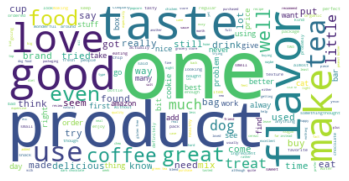

In [56]:
# Please write all the code with proper documentation

from wordcloud import WordCloud
data=''
for sent in cluster_0:
        data += sent

#https://www.geeksforgeeks.org/generating-word-cloud-python/
wordcloud = WordCloud(background_color="white").generate(data)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


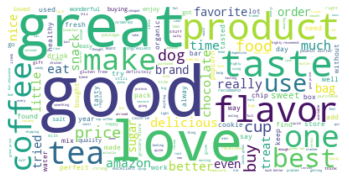

In [57]:
# Please write all the code with proper documentation
data=''
for sent in cluster_1:
        data += sent

#https://www.geeksforgeeks.org/generating-word-cloud-python/
wordcloud = WordCloud(background_color="white").generate(data)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


### [5.3.3] Applying DBSCAN on TFIDF W2V,<font color='red'> SET 4</font>

In [75]:
# Please write all the code with proper documentation
model = TfidfVectorizer(min_df = 500)
model.fit(preprocessed_reviews)
w2v_model = w2v_fit(preprocessed_reviews)

X_train = tf_idf_transform(model,w2v_model,preprocessed_reviews)

In [76]:
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler(with_mean=False)
X_train = scalar.fit_transform(X_train)


In [77]:
min_sample_value = 2 * (X_train.shape[1])

In [78]:

neigh = NearestNeighbors(n_neighbors=X_train.shape[0])
nbrs = neigh.fit(X_train)
distances, indices = nbrs.kneighbors(X_train)

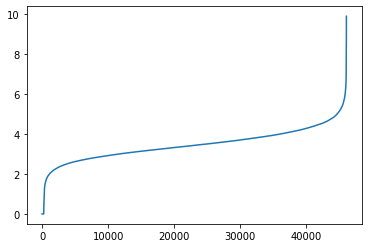

In [79]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

            =================================== eps=4 ===========================================

In [64]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=4, n_jobs=-1,min_samples=min_sample_value)
dbscan.fit(X_train)
#https://www.geeksforgeeks.org/python-get-unique-values-list/
print('No of clusters: ',len(set(dbscan.labels_)))
print(set(dbscan.labels_))

No of clusters:  5
{0, 1, 2, 3, -1}


### [5.3.2] Wordclouds of clusters obtained after applying DBSCAN on TFIDF W2V<font color='red'> SET 3</font>

In [66]:
cluster_0=[]
cluster_1=[]
cluster_2=[]
cluster_3=[]
cluster_4=[]

for i in range(len(preprocessed_reviews)):
    if dbscan.labels_[i] == 0:
        cluster_0.append(preprocessed_reviews[i])
    elif dbscan.labels_[i] == 1:
        cluster_1.append(preprocessed_reviews[i])
    elif dbscan.labels_[i] == 2:
        cluster_2.append(preprocessed_reviews[i])
    elif dbscan.labels_[i] == 3:
        cluster_3.append(preprocessed_reviews[i])
    else:
        cluster_4.append(preprocessed_reviews[i])

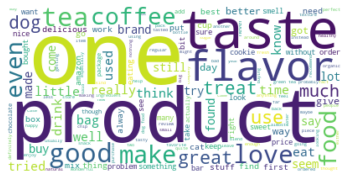

In [67]:
# Please write all the code with proper documentation

from wordcloud import WordCloud
data=''
for sent in cluster_0:
        data += sent

#https://www.geeksforgeeks.org/generating-word-cloud-python/
wordcloud = WordCloud(background_color="white").generate(data)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


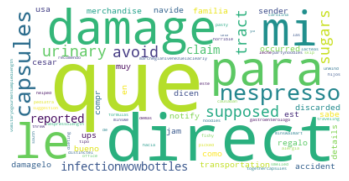

In [68]:
# Please write all the code with proper documentation
data=''
for sent in cluster_1:
        data += sent

#https://www.geeksforgeeks.org/generating-word-cloud-python/
wordcloud = WordCloud(background_color="white").generate(data)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


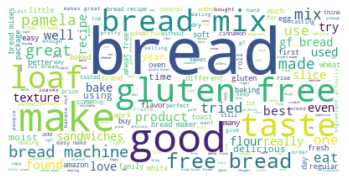

In [69]:
# Please write all the code with proper documentation
data=''
for sent in cluster_2:
        data += sent

#https://www.geeksforgeeks.org/generating-word-cloud-python/
wordcloud = WordCloud(background_color="white").generate(data)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


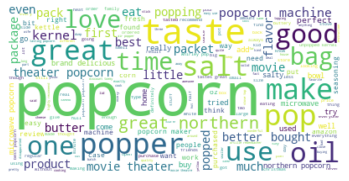

In [70]:
# Please write all the code with proper documentation
data=''
for sent in cluster_3:
        data += sent

#https://www.geeksforgeeks.org/generating-word-cloud-python/
wordcloud = WordCloud(background_color="white").generate(data)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


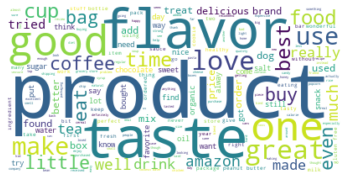

In [71]:
# Please write all the code with proper documentation
data=''
for sent in cluster_4:
        data += sent

#https://www.geeksforgeeks.org/generating-word-cloud-python/
wordcloud = WordCloud(background_color="white").generate(data)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


# [6] Conclusions

In [72]:
# Please compare all your models using Prettytable library. 
# You can have 3 tables, one each for kmeans, agllomerative and dbscan#prettytable for kmeans
from prettytable import PrettyTable    
x = PrettyTable(["Model","Vectorizer","Optimal k"])
x.add_row(['K-means','BOW','6'])
x.add_row(['K-means','TFIDF','6'])
x.add_row(['K-means','AVG W2vec','6'])
x.add_row(['K-means','TFIDF W2vec','6'])
print(x)

+---------+-------------+-----------+
|  Model  |  Vectorizer | Optimal k |
+---------+-------------+-----------+
| K-means |     BOW     |     6     |
| K-means |    TFIDF    |     6     |
| K-means |  AVG W2vec  |     6     |
| K-means | TFIDF W2vec |     6     |
+---------+-------------+-----------+


In [73]:
from prettytable import PrettyTable    
x = PrettyTable(["Model","Vectorizer","K values"])
x.add_row(['Agglomerative','AVG W2vec','2,3'])
x.add_row(['Agglomerative','TFIDF W2vec','2,3'])
print(x)

+---------------+-------------+----------+
|     Model     |  Vectorizer | K values |
+---------------+-------------+----------+
| Agglomerative |  AVG W2vec  |   2,3    |
| Agglomerative | TFIDF W2vec |   2,3    |
+---------------+-------------+----------+


In [74]:
from prettytable import PrettyTable    
x = PrettyTable(["Model","Vectorizer","eps values"])
x.add_row(['DBSCAN','AVG W2vec','5'])
x.add_row(['DBSCAN','TFIDF W2vec','4'])
print(x)


+--------+-------------+------------+
| Model  |  Vectorizer | eps values |
+--------+-------------+------------+
| DBSCAN |  AVG W2vec  |     5      |
| DBSCAN | TFIDF W2vec |     4      |
+--------+-------------+------------+


Summary :

1. Text preprocessing was done on the reviews column of the dataset.
2. For K means clustering 50k datapoints were considered and for Aggolmerative and DBSCAN 3k datapoints were considered.
3. The optimal k value hyperparameter for Kmeans on BOW,TFIDF,AVGW2V and TFIDFW2V vectorizers was tuned based on inertia value using elbow method.
4. The words in each clusters for each of the vectorizers were displayed using word cloud .
5. Incase of agglomerative clustering we considered number of clusters to be 2 and 3 on AVGW2V and TFIDFW2V vectorizers and clusters were displayed.
6. Incase of DBSCAN clustering minsample parameter was set to 2 *(dimesions length). The parameter eps was tuned by K-distance graph.
